# TASK1 - EDA

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

customer=pd.read_csv(r"C:\Users\dell\Downloads\Customers (1).csv")
transaction=pd.read_csv(r"C:\Users\dell\Downloads\Transactions.csv")
products=pd.read_csv(r"C:\Users\dell\Downloads\Products (1).csv")

In [4]:
customer.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [5]:
transaction.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [6]:
products.head()

,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31


In [7]:
customer.isnull().sum()

CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64

In [8]:
products.isnull().sum()

ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64

In [9]:
transaction.isnull().sum()

TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64

In [12]:
products.duplicated().any()

False

In [13]:
transaction.duplicated().any()

False

In [14]:
customer.duplicated().any()

False

In [16]:
region_counts = customer['Region'].value_counts()


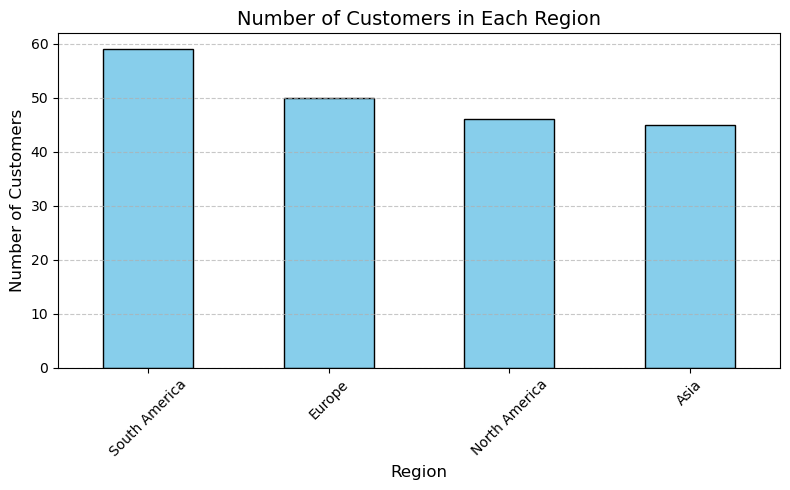

In [18]:

plt.figure(figsize=(8, 5))
region_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Customers in Each Region', fontsize=14)

plt.xlabel('Region', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [20]:
merged_data = pd.merge(transaction, products, on='ProductID', how='left')
product_quantity = merged_data.groupby('ProductName')['Quantity'].sum().reset_index()
top_product = product_quantity.sort_values(by='Quantity', ascending=False).iloc[0]
print(f"The product sold the most is: {top_product['ProductName']} with {top_product['Quantity']} units sold.")

The product sold the most is: ActiveWear Smartwatch with 100 units sold.


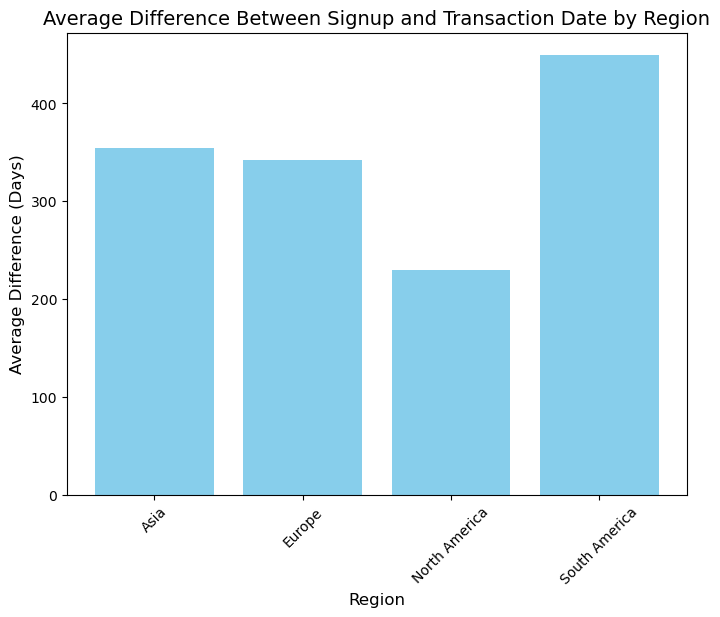

In [27]:
customer['SignupDate'] = pd.to_datetime(customer['SignupDate'])
transaction['TransactionDate'] = pd.to_datetime(transaction['TransactionDate'])
merged_data1 = pd.merge(customer, transaction, on="CustomerID", how="inner")
merged_data1['DaysDifference'] = (merged_data1['TransactionDate'] - merged_data1['SignupDate']).dt.days
average_diff_by_region = merged_data1.groupby('Region')['DaysDifference'].mean().reset_index()
plt.figure(figsize=(8, 6))
plt.bar(average_diff_by_region['Region'], average_diff_by_region['DaysDifference'], color='skyblue')
plt.xlabel('Region', fontsize=12)
plt.ylabel('Average Difference (Days)', fontsize=12)
plt.title('Average Difference Between Signup and Transaction Date by Region', fontsize=14)
plt.xticks(rotation=45)
plt.show()

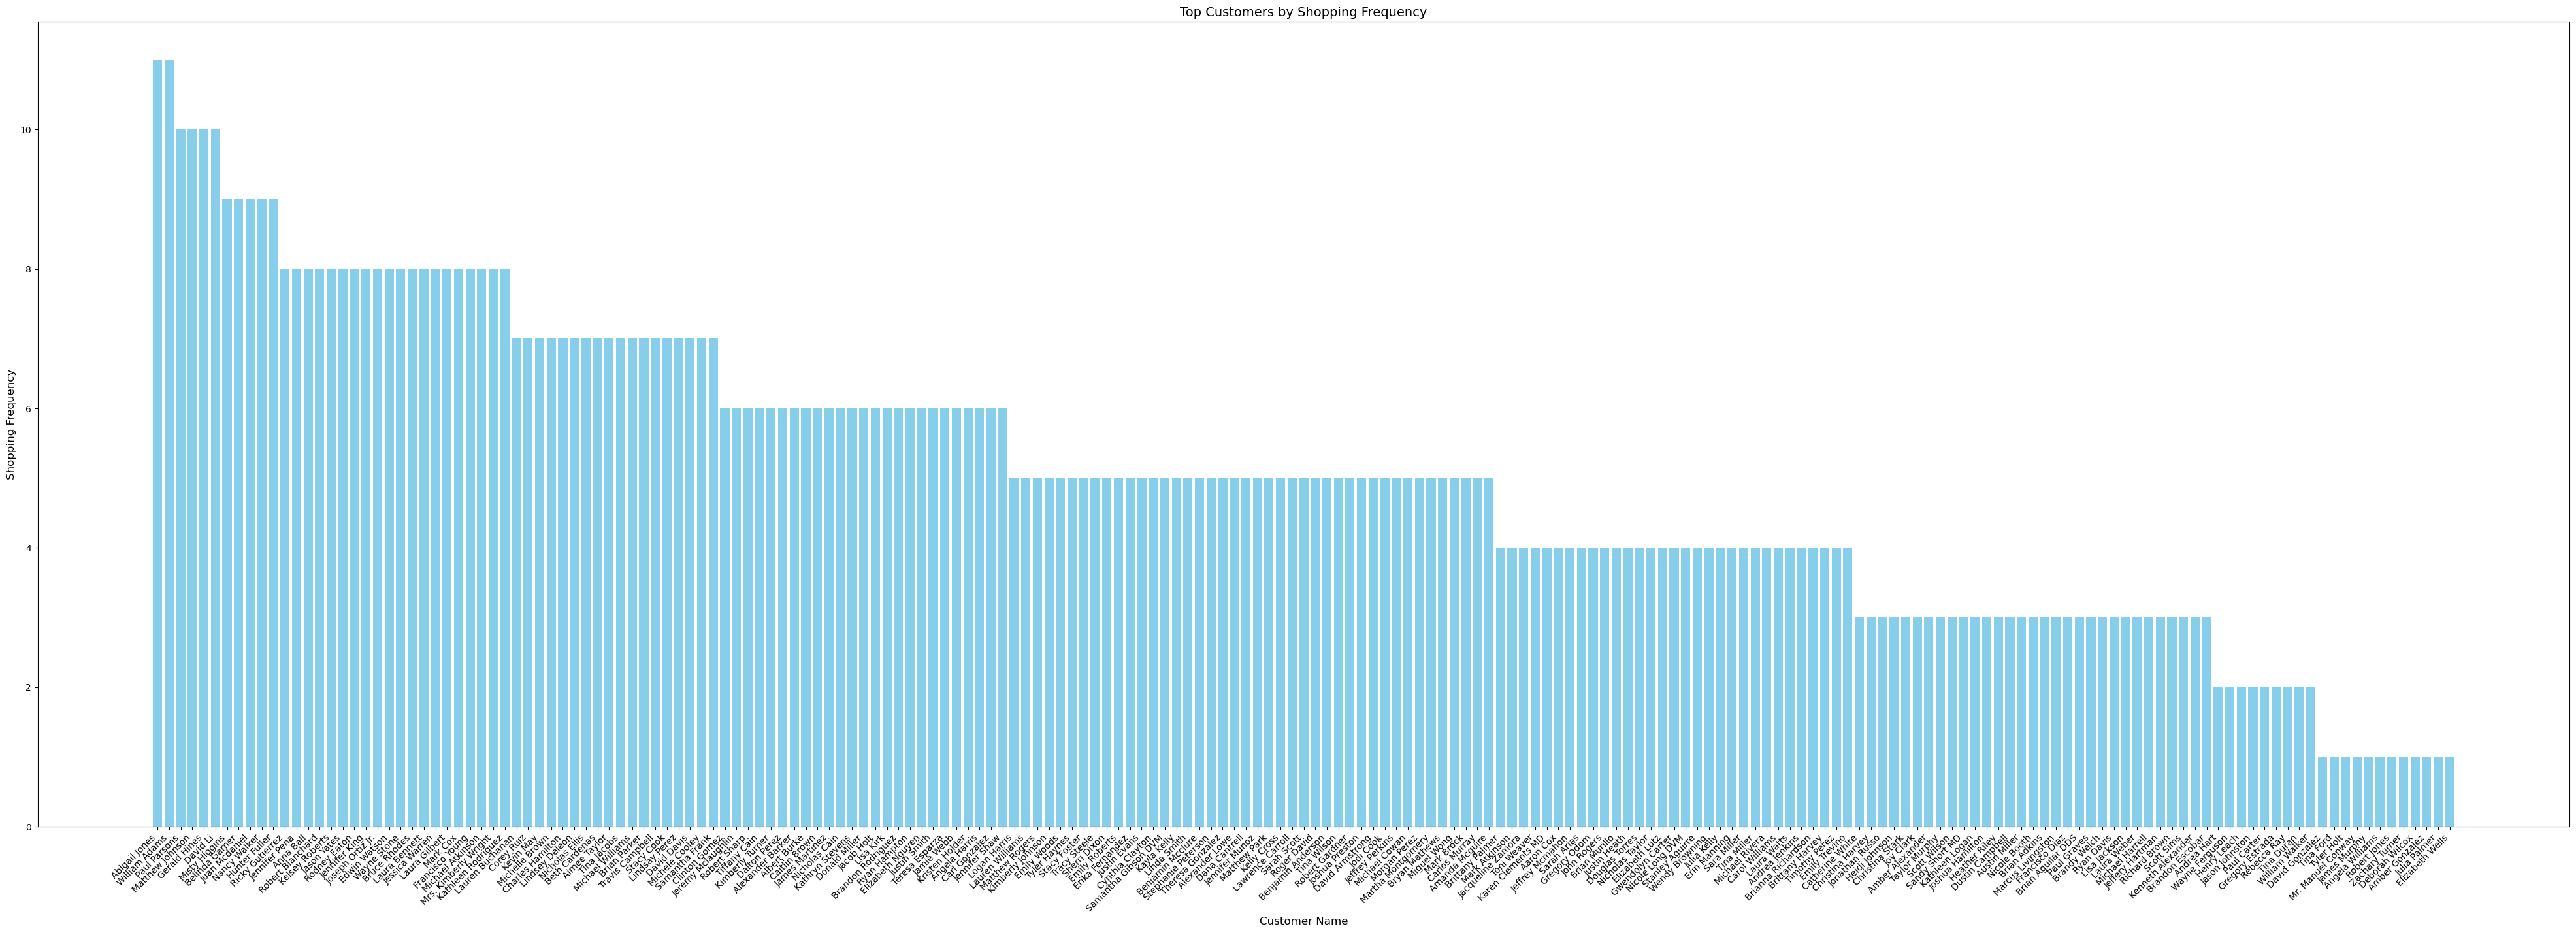

In [26]:
shopping_frequency = transactions['CustomerID'].value_counts().reset_index()
shopping_frequency.columns = ['CustomerID', 'Frequency']

frequency_with_names = pd.merge(shopping_frequency, customer[['CustomerID', 'CustomerName']], on="CustomerID", how="left")

frequency_with_names = frequency_with_names.sort_values(by="Frequency", ascending=False)

plt.figure(figsize=(50, 16))
plt.bar(frequency_with_names['CustomerName'], frequency_with_names['Frequency'], color='skyblue')
plt.xlabel('Customer Name', fontsize=12)
plt.ylabel('Shopping Frequency', fontsize=12)
plt.title('Top Customers by Shopping Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

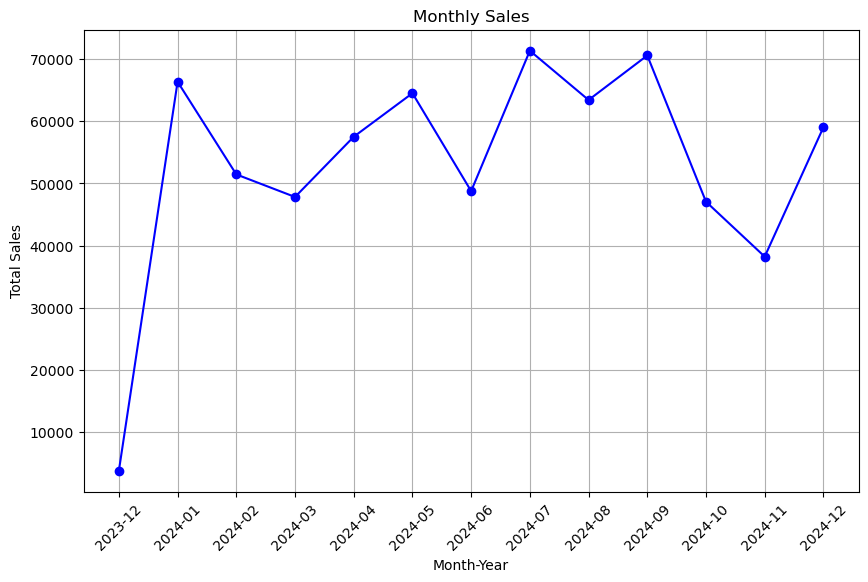

In [28]:
merged_data1['MonthYear'] = pd.to_datetime(merged_data1['TransactionDate']).dt.to_period('M')

monthly_sales = merged_data1.groupby('MonthYear')['TotalValue'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(monthly_sales['MonthYear'].astype(str), monthly_sales['TotalValue'], marker='o', color='b')
plt.title('Monthly Sales')
plt.xlabel('Month-Year')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# TASK 2 - LOOKALIKE

In [30]:
transactions_df = pd.merge(transaction, customer[['CustomerID', 'Region']], on='CustomerID', how='left')
full_data = pd.merge(transactions_df, products[['ProductID', 'ProductName', 'Category', 'Price']], on='ProductID', how='left')

In [31]:
customer_features = full_data.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    total_transactions=('TransactionID', 'count'),
    unique_categories=('Category', 'nunique')
).reset_index()

In [32]:
customer_features = pd.merge(customer_features, customer[['CustomerID', 'Region']], on='CustomerID', how='left')

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
customer_features[['total_spent', 'total_transactions', 'unique_categories']] = scaler.fit_transform(
    customer_features[['total_spent', 'total_transactions', 'unique_categories']]
)

In [34]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(customer_features[['total_spent', 'total_transactions', 'unique_categories']])
similarity_df = pd.DataFrame(similarity_matrix, columns=customer_features['CustomerID'], index=customer_features['CustomerID'])

In [36]:
lookalikes = {}

for customer in customer_features['CustomerID']:
    sim_scores = similarity_df[customer].sort_values(ascending=False)
    sim_scores = sim_scores.drop(customer).head(3)
    lookalikes[customer] = list(zip(sim_scores.index, sim_scores.values))
lookalike_list = []
for customer_id, similar_customers in lookalikes.items():
    for similar_customer, score in similar_customers:
        lookalike_list.append([customer_id, similar_customer, score])


lookalike_df = pd.DataFrame(lookalike_list, columns=['CustomerID', 'LookalikeCustomerID', 'SimilarityScore'])


lookalike_df.to_csv('Lookalike.csv', index=False)


# TASK 3 - CLUSTERING

In [42]:
customer_df=pd.read_csv(r"C:\Users\dell\Downloads\Customers (1).csv")

In [40]:
transaction.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [43]:
transaction_agg = transaction.groupby('CustomerID').agg(
    total_spend=('TotalValue', 'sum'),
    num_transactions=('TransactionID', 'count')
).reset_index()

customer_data = pd.merge(customer_df, transaction_agg, on='CustomerID', how='left')


customer_data.fillna(0, inplace=True)

In [44]:
customer_data['SignupDate'] = pd.to_datetime(customer_data['SignupDate'])
customer_data['days_since_signup'] = (pd.to_datetime('today') - customer_data['SignupDate']).dt.days
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

In [45]:
features = ['total_spend', 'num_transactions', 'days_since_signup'] + [col for col in customer_data if 'Region' in col]
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[features])

In [48]:
n_clusters = 4 


kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
customer_data['cluster'] = kmeans.fit_predict(customer_data_scaled)


cluster_centers = kmeans.cluster_centers_

<IPython.core.display.Javascript object>

D:\Anaconda New\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [49]:
from sklearn.metrics import davies_bouldin_score
db_index = davies_bouldin_score(customer_data_scaled, customer_data['cluster'])
print(f'Davies-Bouldin Index: {db_index}')

Davies-Bouldin Index: 1.2466807448049195


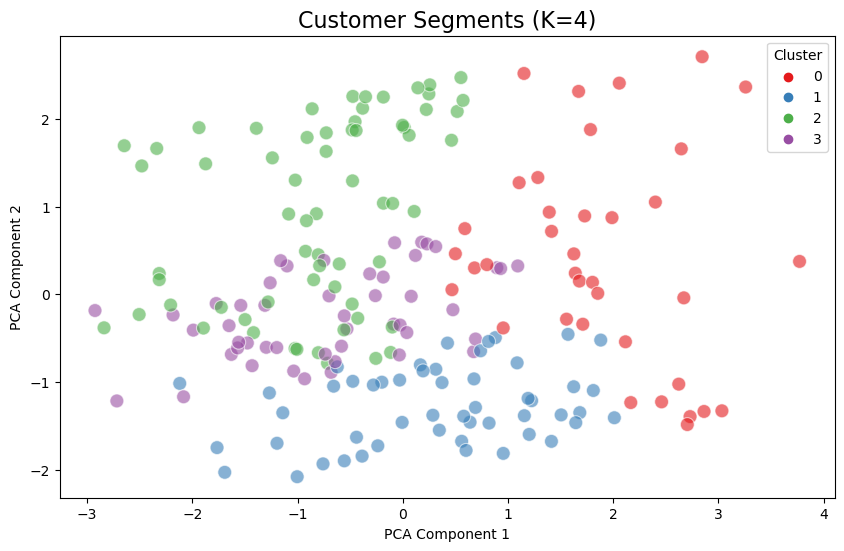

In [50]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
customer_data_pca = pca.fit_transform(customer_data_scaled)
customer_data['pca1'] = customer_data_pca[:, 0]
customer_data['pca2'] = customer_data_pca[:, 1]


plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=customer_data, palette='Set1', s=100, alpha=0.6)
plt.title(f'Customer Segments (K={n_clusters})', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [51]:
customer_data.to_csv('Segmented_Customers.csv', index=False)

In [53]:
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(customer_data_scaled, customer_data['cluster'])
inertia = kmeans.inertia_
print(f'Silhouette Score: {sil_score}')
print(f'Inertia: {inertia}')

Silhouette Score: 0.32167557623100396
Inertia: 583.2289587502912
